In [161]:
import numpy as np
import nengo
import nengo.spa as spa
import world
import kitchen
import nodes
import matplotlib.pyplot as plt
%matplotlib inline

D = 256

test_world = kitchen.get_kitchen()
# test_world.do('KETTLE','UNPLUG_KETTLE')
test_world.print_state()

effects = ['WATER_IN_KETTLE', 'KETTLE_UNDER_TAP', 'WATER_BOILED', 'KETTLE_PLUGGED_IN', 'KETTLE_UNPLUGGED']
actions = ['FILL_KETTLE_FROM_TAP', 'PUT_KETTLE_UNDER_TAP', 'BOIL_KETTLE', 'PLUG_IN_KETTLE','UNPLUG_KETTLE']
precons = ['KETTLE_UNDER_TAP','KETTLE_UNPLUGGED','WATER_IN_KETTLE','KETTLE_PLUGGED_IN','HAS_CORD']
signals = ['PLAN','EXECUTE','NULL','DONE']

effect_vocab = spa.Vocabulary(D)
action_vocab = spa.Vocabulary(D)
precon_vocab = spa.Vocabulary(D)
signal_vocab = spa.Vocabulary(D)
count_vocab = spa.Vocabulary(D)

for effect in effects:
    effect_vocab.parse(effect)
    
for action in actions:
    action_vocab.parse(action)

for precon in precons:
    precon_vocab.parse(precon)  

for sig in signals:
    signal_vocab.parse(sig)
    
action_vocab['INDEX'].make_unitary()

# Counter Vocabulary
count_vocab['ONE'].make_unitary()
count_vocab.add('TWO', count_vocab['ONE']*count_vocab['ONE'])
count_vocab.add('THREE', count_vocab['TWO']*count_vocab['ONE'])

mapping = np.zeros((D, len(action_vocab.keys)))

# Check for no outstanding preconditions.
mapping[:,0] = signal_vocab['NULL'].v
mapping[:,1] = signal_vocab['NULL'].v
mapping[:,2] = signal_vocab['NULL'].v
mapping[:,3] = signal_vocab['NULL'].v
mapping[:,4] = signal_vocab['EXECUTE'].v
mapping[:,5] = signal_vocab['NULL'].v

inp_vecs = np.zeros((3, D))
out_vecs = np.zeros((3, D))

inp_vecs[0,:] = action_vocab['FILL_KETTLE_FROM_TAP'].v
inp_vecs[1,:] = action_vocab['PUT_KETTLE_UNDER_TAP'].v
inp_vecs[2,:] = action_vocab['BOIL_KETTLE'].v

out_vecs[0,:] = effect_vocab['KETTLE_UNDER_TAP'].v
out_vecs[1,:] = effect_vocab['KETTLE_UNPLUGGED'].v
out_vecs[2,:] = effect_vocab['WATER_IN_KETTLE'].v + 1.2*effect_vocab['KETTLE_PLUGGED_IN'].v

WATER
{'TEMPERATURE': 'COLD'}
------------------
KETTLE
{'PLUGGED': 'PLUGGED_IN'}
ON-COUNTER
------------------
TAP
{'OFFON': 'OFF'}
------------------
COUNTER
{}
------------------


In [162]:
from nengo.networks import AssociativeMemory 

motor_sys = nodes.MotorSystem(action_vocab, test_world)
vision_sys = nodes.VisualSystem(effect_vocab, test_world)

with spa.SPA(label='Planner Test') as model:

    # For managing control signals
    model.ctrl = spa.Memory(dimensions=D, tau=0.05) 
    model.switch = spa.Memory(dimensions=D, vocab=signal_vocab, tau=0.02)
    
    # For counting
#     model.inc = spa.Memory(dimensions=D, vocab=count_vocab, tau=0.05)
#     model.count = spa.Memory(dimensions=D, vocab=count_vocab, tau=0.5)
    
    # Main state representations    
    model.m_goal = spa.Memory(dimensions=D, vocab=effect_vocab)
    model.i_goal = spa.Memory(dimensions=D, vocab=effect_vocab, synapse=0.005, tau=0.35)
    model.action = spa.Memory(dimensions=D, vocab=action_vocab, synapse=0.005, tau=0.05)
    model.effect = spa.Memory(dimensions=D, vocab=effect_vocab, synapse=0.005, tau=0.05)
    model.precon = spa.Memory(dimensions=D, vocab=effect_vocab, synapse=0.005, tau=0.05)

    # Associative Memories 
    model.goal_to_action = spa.AssociativeMemory(input_vocab=effect_vocab, output_vocab=action_vocab, 
                                                 input_keys=effects, output_keys=actions, wta_output=True)
    
    model.action_to_effect = spa.AssociativeMemory(input_vocab=action_vocab, output_vocab=effect_vocab,
                                                   input_keys=actions, output_keys=effects, wta_output=True)
    
    model.action_to_signal = AssociativeMemory(input_vectors=action_vocab.vectors, output_vectors=mapping.T)
   
    # Multiple Precons Test
    model.rp_test = spa.State(dimensions=D, vocab=action_vocab)
    model.am_test = AssociativeMemory(input_vectors=inp_vecs, output_vectors=out_vecs)  
    nengo.Connection(model.rp_test.output, model.am_test.input)
    nengo.Connection(model.am_test.output, model.precon.state.input)
        
    # Stack implementation
    model.push = spa.Memory(dimensions=D, vocab=action_vocab, synapse=0.005, tau=0.05)
    model.stack = spa.Memory(dimensions=D, vocab=action_vocab, synapse=0.005, tau=0.5)
    model.top = spa.Memory(dimensions=D, vocab=action_vocab, synapse=0.005, tau=0.03)
    
    model.sig = spa.Memory(dimensions=D, vocab=signal_vocab, synapse=0.1)

    model.clean_action = spa.AssociativeMemory(action_vocab, threshold=0.15)

    bg_actions = spa.Actions(
        'dot(ctrl, PLAN)       -->  i_goal=m_goal, ctrl=GET_ACTION',
        'dot(ctrl, GET_ACTION) -->  goal_to_action=1.5*i_goal, ctrl=GET_PRECON',
        'dot(ctrl, GET_PRECON) -->  rp_test=1.5*action, push=1.5*(stack*INDEX+action), ctrl=SET_GOAL',
        'dot(ctrl, SET_GOAL)   -->  i_goal=1.5*i_goal+1.2*precon-effect, stack=push, ctrl=GET_ACTION',
        
        'dot(switch, EXECUTE)  -->  ctrl=TOP_STACK',
        'dot(ctrl, TOP_STACK)  -->  clean_action=stack, ctrl=POP_STACK',
        'dot(ctrl, POP_STACK)  -->  push=(stack-top)*~INDEX, ctrl=SET_STACK',
        'dot(ctrl, SET_STACK)  -->  stack=10*push, ctrl=TOP_STACK, sig=1.2*PLAN',
        'dot(sig, PLAN)        -->  ctrl=PLAN',
#         'dot(ctrl, INC)        -->  inc=2*(count*ONE), ctrl=UPDATE',
#         'dot(ctrl, UPDATE)     -->  count=2*inc, ctrl=TOP_STACK',
        
#         'dot(count, 1.5*THREE)     -->  ctrl=PLAN, i_goal=m_goal',
#         'dot(goal_stat, DONE)  -->  ctrl=STOP',
        '0.35                  -->  ')

    ct_actions = spa.Actions(
        'action_to_effect=action',
        'effect=action_to_effect',
        'action=goal_to_action',
        'top=clean_action')
    
    model.bg = spa.BasalGanglia(bg_actions)
    model.ct = spa.Cortical(ct_actions)
    model.thal = spa.Thalamus(model.bg)

    def set_goal(t):
        return 'WATER_BOILED'

    def set_plan(t):
        if 0.03 < t < 0.07: return 'PLAN'
        else: return '0'

    model.start = spa.Input(m_goal=set_goal, ctrl=set_plan)

    model.motor = nengo.Node(motor_sys, size_in=D, size_out=1)
    model.sense = nengo.Node(vision_sys, size_in=D, size_out=1)

    # Node Connections
    nengo.Connection(model.i_goal.state.output, model.sense[:])
    nengo.Connection(model.top.state.output, model.motor[:])
    
    nengo.Connection(model.sense, model.switch.state.input, transform=signal_vocab['EXECUTE'].v.reshape(D,1))
    
    # Compare and AssocMem Connections
    nengo.Connection(model.action.state.output, model.action_to_signal.input)
    nengo.Connection(model.action_to_signal.output, model.switch.state.input, transform=0.6)
    
    # Probes
    goal_probe = nengo.Probe(model.i_goal.state.output, synapse=0.03)
    mgoal_probe = nengo.Probe(model.m_goal.state.output, synapse=0.03)
    plan_probe = nengo.Probe(model.ctrl.state.output, synapse=0.03)
    action_probe = nengo.Probe(model.action.state.output, synapse=0.03)
    precon_probe = nengo.Probe(model.precon.state.output, synapse=0.03)
    top_probe = nengo.Probe(model.top.state.output, synapse=0.03)
    stack_probe = nengo.Probe(model.stack.state.output, synapse=0.03)
    push_probe = nengo.Probe(model.push.state.output, synapse=0.03)
    motor_probe = nengo.Probe(model.motor)
    sense_probe = nengo.Probe(model.sense)
    sig_probe = nengo.Probe(model.sig.state.output, synapse=0.03)
#     inc_probe = nengo.Probe(model.inc.state.output, synapse=0.03)
#     counter_probe = nengo.Probe(model.count.state.output, synapse=0.03)
    effect_probe = nengo.Probe(model.effect.state.output, synapse=0.03)
    goal_to_act_probe = nengo.Probe(model.goal_to_action.output, synapse=0.03)
    switch_probe = nengo.Probe(model.switch.state.output, synapse=0.03)

sim = nengo.Simulator(model, seed=np.random.randint(1))

In [163]:
def plot_results_full(sim):
    fig = plt.figure(figsize=(18,12))

    p1 = fig.add_subplot(7,1,1)
    p1.plot(sim.trange(), model.similarity(sim.data, goal_probe))
    p1.legend(model.get_output_vocab('i_goal').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p1.set_ylabel('Goal')

    p2 = fig.add_subplot(7,1,2)
    p2.plot(sim.trange(), model.similarity(sim.data, plan_probe))
    p2.legend(model.get_output_vocab('ctrl').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=10)
    p2.set_ylabel('Control Signal')

    p3 = fig.add_subplot(7,1,3)
    p3.plot(sim.trange(), model.similarity(sim.data, action_probe))
    p3.legend(model.get_output_vocab('action').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p3.set_ylabel('Action')

    p4 = fig.add_subplot(7,1,4)
    p4.plot(sim.trange(), model.similarity(sim.data, precon_probe))
    p4.legend(model.get_output_vocab('precon').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p4.set_ylabel('Precondition')

    p5 = fig.add_subplot(7,1,5)
    p5.plot(sim.trange(), model.similarity(sim.data, push_probe))
    p5.legend(model.get_output_vocab('push').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p5.set_ylabel('Push')

    p6 = fig.add_subplot(7,1,6)
    p6.plot(sim.trange(), model.similarity(sim.data, stack_probe))
    p6.legend(model.get_output_vocab('stack').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p6.set_ylabel('Stack')

    p7 = fig.add_subplot(7,1,7)
    p7.plot(sim.trange(), model.similarity(sim.data, top_probe))
    p7.legend(model.get_output_vocab('top').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p7.set_ylabel('Popped')
    
    fig.subplots_adjust(hspace=0.75)
    plt.show()
    
def plot_additional(sim):
    fig = plt.figure(figsize=(18,12))

    p1 = fig.add_subplot(7,1,1)
    p1.plot(sim.trange(), model.similarity(sim.data, effect_probe))
    p1.legend(model.get_output_vocab('effect').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p1.set_ylabel('Effect')

    p2 = fig.add_subplot(7,1,2)
    p2.plot(sim.trange(), model.similarity(sim.data, mgoal_probe))
    p2.legend(model.get_output_vocab('m_goal').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p2.set_ylabel('Main Goal')
    
    p3 = fig.add_subplot(7,1,3)
    p3.plot(sim.trange(), sim.data[sense_probe])
    p3.set_ylabel('Sensory Feedback')

    p4 = fig.add_subplot(7,1,4)
    p4.plot(sim.trange(), sim.data[motor_probe])
    p4.set_ylabel('Motor Execution')

#     p5 = fig.add_subplot(7,1,5)
#     p5.plot(sim.trange(), model.similarity(sim.data, counter_probe))
#     p5.legend(model.get_output_vocab('count').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
#     p5.set_ylabel('Counter')
    
    p6 = fig.add_subplot(7,1,6)
    p6.plot(sim.trange(), model.similarity(sim.data, sig_probe))
    p6.legend(model.get_output_vocab('sig').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p6.set_ylabel('Signal')
    
    p7 = fig.add_subplot(7,1,7)
    p7.plot(sim.trange(), model.similarity(sim.data, switch_probe))
    p7.legend(model.get_output_vocab('switch').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p7.set_ylabel('Switch')

    fig.subplots_adjust(hspace=1)
    fig.show()

In [164]:
# sim.reset()
sim.run(2.5)

[##################           29%                              ] ETA: 0:01:26performing action UNPLUG_KETTLE
[#####################        35%                              ] ETA: 0:01:20performing action PUT_KETTLE_UNDER_TAP
[############################ 59% ###                          ] ETA: 0:00:51performing action FILL_KETTLE_FROM_TAP
[############################ 75% ##############               ] ETA: 0:00:30performing action BOIL_KETTLE
[############################ 91% #######################      ] ETA: 0:00:11performing action BOIL_KETTLE
Simulation finished in 0:02:05.                                                 


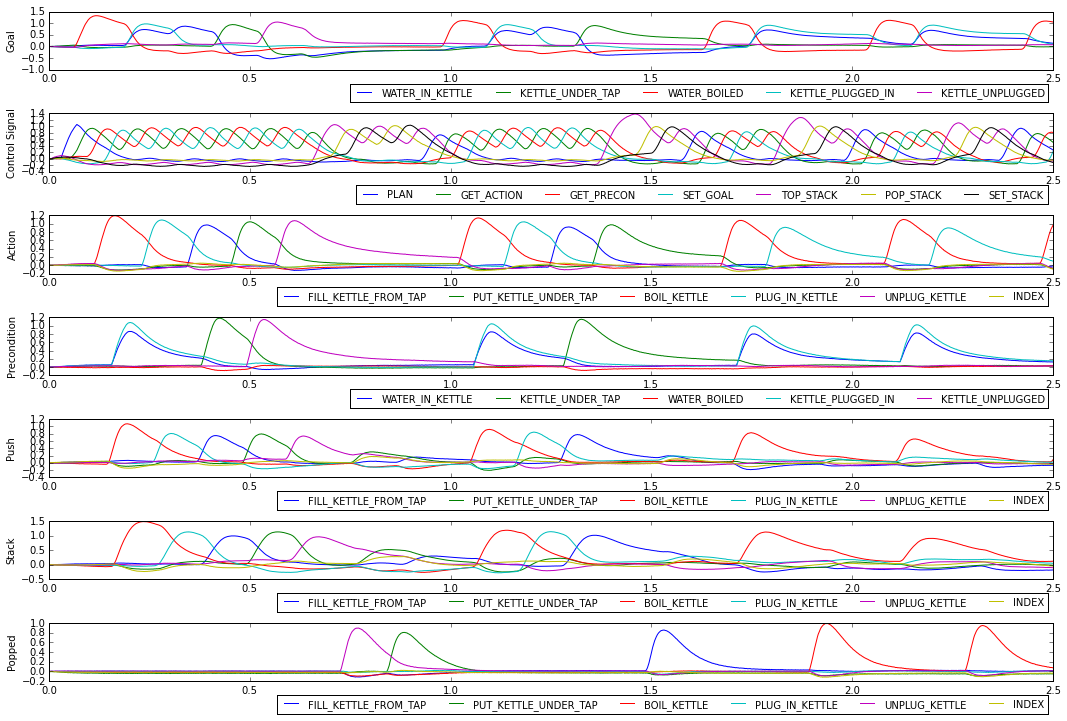

WATER
{'TEMPERATURE': 'COLD'}
IN-KETTLE
------------------
KETTLE
{'PLUGGED': 'UNPLUGGED'}
UNDER-TAP
------------------
TAP
{'OFFON': 'OFF'}
------------------
COUNTER
{}
------------------


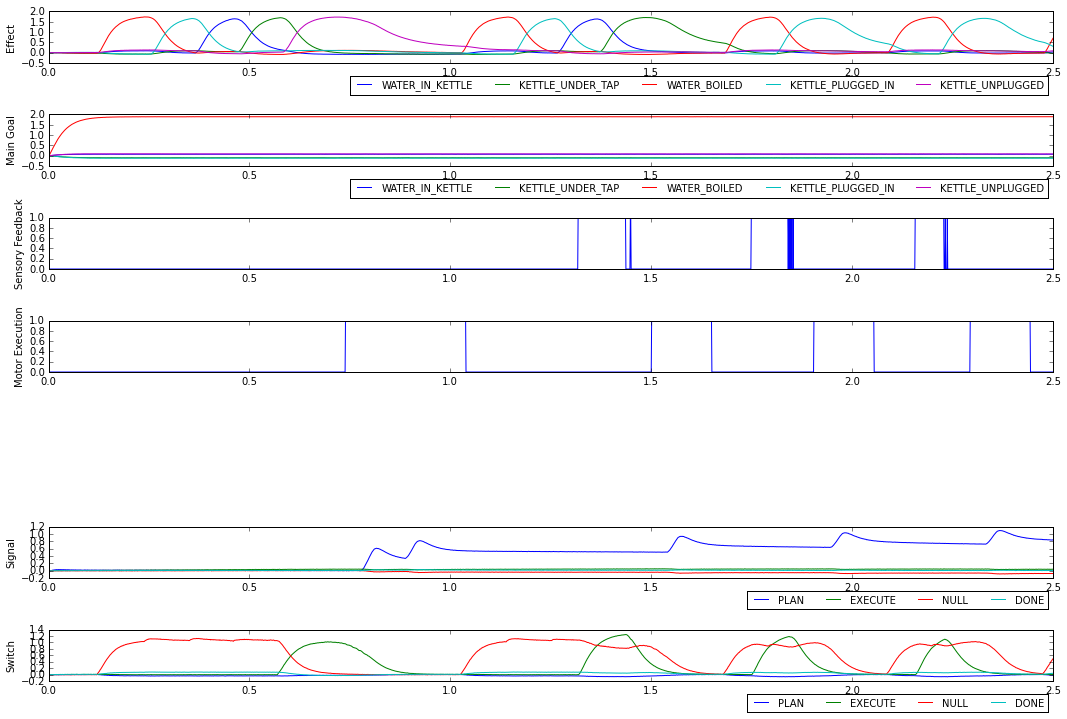

In [165]:
plot_results_full(sim)
test_world.print_state()
plot_additional(sim)

In [166]:
# # Test if model's stack can be used symbolically (i.e. whether failure is in popping stage)
# def get_key(vocab, pointer, threshold):
#     key = None
#     similarities = vocab.dot(pointer)
#     ind = np.argmax(similarities)
#     print similarities[ind]
#     if similarities[ind] >= threshold:
#         key = vocab.keys[ind]
#     return key

# stack = sim.data[stack_probe][600]
# top = get_key(action_vocab, stack, 0.3)
# print top

# stack = spa.pointer.SemanticPointer(stack - action_vocab[top].v) * ~action_vocab['INDEX']
# top = get_key(action_vocab, stack, 0.3)
# print top

# stack = spa.pointer.SemanticPointer(stack.v - action_vocab[top].v) * ~action_vocab['INDEX']
# top = get_key(action_vocab, stack, 0.3)
# print top